# Bayesian Optimization Demo
*Joachim van der Herten*

In Bayesian Optimization, the typical goal is optimizing an *expensive*-to-evaluate function $f: \mathcal{X} \rightarrow \mathbb{R}^p$: 
$$ \underset{\boldsymbol{x}}{\operatorname{argmin}} f(\boldsymbol{x})$$
over the optimization domain $\mathcal{X} \subset \mathbb{R}^d$ by evaluating $f$ on a sequence of decisions $\boldsymbol{x}_0, \boldsymbol{x}_1, ... \boldsymbol{x}_{n-1}$. Each decision $\boldsymbol{x}_i \in \mathcal{X}$ itself is the result of an optimization problem
$$\boldsymbol{x}_i = \underset{\boldsymbol{x}}{\operatorname{argmax}} \alpha_i(\boldsymbol{x})$$
The function $\alpha$ acts as a surrogate for the expensive function, and is cheap-to-evaluate. It is typically a mapping of the predictive distribution of a model built on all decisions and their corresponding (noisy) evaluations. The mapping introduces an order in $\mathcal{X}$ to obtain a certain goal. The typical goal within the context of Bayesian Optimization is typically to obtain *optimality* or *feasibility* with a small number of evaluations of $f$. As we can have several functions $f$ representing objectives and constraints, Bayesian Optimization may invoke several models and mappings $\alpha$. The mappings are typically referred to as *acquisition functions*.

In [1]:
%matplotlib inline
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
import matplotlib.pyplot as plt

import GPflow
import OptDemo
import numpy as np

This notebook demonstrates the optimization of an analytical function using the well known Expected Improvement (EI) function. In addition, a black-box constraint function is added to the optimization. The feasible regions are learnt jointly with the optimal regions by considering a second acquisition function known as the Probability of Feasibility (PoF), following the approach of Gardner et al. (2014)

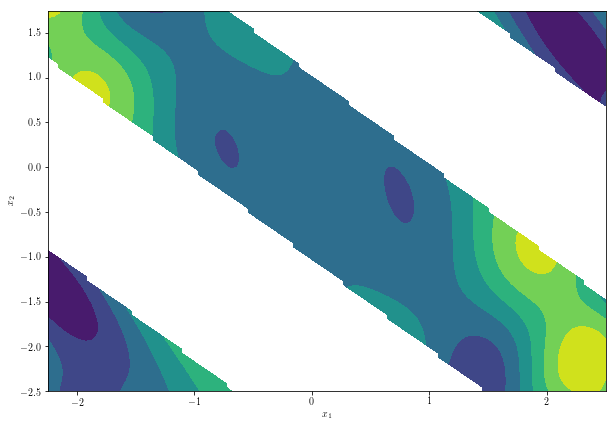

In [2]:
# Objective & constraint
def townsend(X):
    return -(np.cos((X[:,0]-0.1)*X[:,1])**2 + X[:,0] * np.sin(3*X[:,0]+X[:,1]))[:,None]

def constraint(X):
    return -(-np.cos(1.5*X[:,0]+np.pi)*np.cos(1.5*X[:,1])+np.sin(1.5*X[:,0]+np.pi)*np.sin(1.5*X[:,1]))[:,None]

# Setup input domain
domain = OptDemo.domain.ContinuousParameter('x1', -2.25, 2.5) + \
        OptDemo.domain.ContinuousParameter('x2', -2.5, 1.75)

# Plot
def plotfx():  
    X = OptDemo.design.FactorialDesign(101, domain).generate()
    Zo = townsend(X)
    Zc = constraint(X)
    mask = Zc>=0
    Zc[mask] = np.nan
    Zc[np.logical_not(mask)] = 1
    Z = Zo * Zc
    shape = (101, 101)

    f, axes = plt.subplots(1, 1, figsize=(10, 7))
    axes.contourf(X[:,0].reshape(shape), X[:,1].reshape(shape), Z.reshape(shape))
    axes.set_xlabel('$x_1$')
    axes.set_ylabel('$x_2$')
    return axes

plotfx()

We proceed by assigning the objective and constraint function a GP prior. Both functions are evaluated on a space-filling set of points (here, a grid). Two GPR models are created, the EI and PoF acquisition functions are created and multiplied into a joint criterion.

In [3]:
# Initial evaluations
design = OptDemo.design.FactorialDesign(4, domain)
X = design.generate()
Yo = townsend(X)
Yc = constraint(X)

# Models
objective_model = GPflow.gpr.GPR(X, Yo, GPflow.kernels.Matern52(2, ARD=True))
constraint_model = GPflow.gpr.GPR(X, Yc, GPflow.kernels.Matern52(2, ARD=True))

# Setup
ei = OptDemo.acquisition.ExpectedImprovement(objective_model)
pof = OptDemo.acquisition.ProbabilityOfFeasibility(constraint_model)
joint = ei * pof

We can now inspect our belief about the optimization problem by plotting the models, and the EI, PoF and joint mappings.

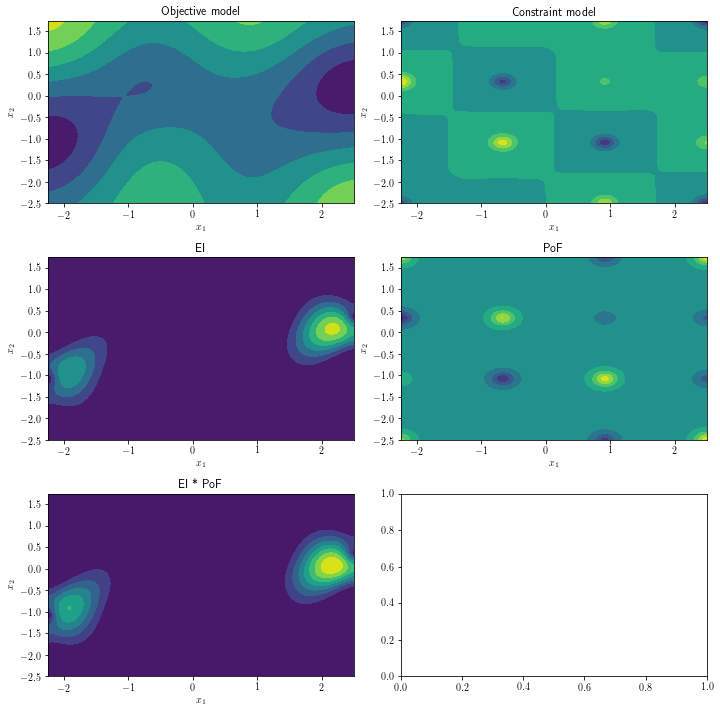

In [4]:
def plot():
    Xeval = OptDemo.design.FactorialDesign(101, domain).generate()
    Yevala,_ = objective_model.predict_f(Xeval)
    Yevalb,_ = constraint_model.predict_f(Xeval)
    Yevalc = ei.evaluate(Xeval)
    Yevald = pof.evaluate(Xeval)
    Yevale = joint.evaluate(Xeval)
    shape = (101, 101)
    plots = [('Objective model', Yevala), ('Constraint model', Yevalb), 
             ('EI', Yevalc), ('PoF', Yevald), 
             ('EI * PoF', Yevale)]

    f, axes = plt.subplots(3, 2, figsize=(10, 10))
    for ax, plot in zip(axes.ravel(), plots):
        ax.contourf(Xeval[:,0].reshape(shape), Xeval[:,1].reshape(shape), 
                    plot[1].reshape(shape))
        ax.set_title(plot[0])
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
    plt.tight_layout()
    
# Plot representing the model belief, and the belief mapped to EI and PoF
plot()


Running the Bayesian optimization is the next step. For this, we must set up an appropriate strategy to optimize the joint acquisition function. Sometimes this can be a bit challenging as often large non-varying areas may occur. A typical strategy is to apply a Monte Carlo optimization step first, then optimize the point with the best value (several variations exist). This approach is followed here. We then run the Bayesian Optimization and allow it to select up to 50 additional decisions. 

The joint acquisition function assures the feasibility (w.r.t the constraint) is taken into account while selecting decisions for optimality.

In [5]:
# Run the Bayesian Optimization

# First setup the optimization strategy for the acquisition function
# Combining MC step followed by L-BFGS-B
acquisition_opt = OptDemo.optim.StagedOptimizer([OptDemo.optim.MCOptimizer(domain, 200), 
                                                   OptDemo.optim.SciPyOptimizer(domain)])

# Then run the BayesianOptimizer for 50 iterations
optimizer = OptDemo.BayesianOptimizer(domain, joint, optimizer=acquisition_opt)
optimizer.optimize([townsend, constraint], n_iter=50)

TypeError: 'list' object is not callable

If we now plot the belief, we clearly see the constraint model has improved significantly. More specifically, its PoF mapping is an accurate representation of the true constraint function.

In [ ]:
# Plotting belief again
plot()

If we inspect the sampling distribution, we can see that the amount of samples in the infeasible regions is limited. The optimization has focussed on the feasible areas. In addition, it has been active mostly in two optimal regions.

In [ ]:
# Plot function, overlayed by the constraint. Also plot the samples
axes = plotfx()
valid = joint.data[1][:,1] < 0
axes.scatter(joint.data[0][valid,0], joint.data[0][valid,1])
axes.scatter(joint.data[0][np.logical_not(valid),0], joint.data[0][np.logical_not(valid),1])